

Bu notebook, kredi karti dolandiricilik tespiti icin iki farkli makine ogrenimi modeli uygular:
1. **Support Vector Machine (SVM - RBF Kernel)** - Margin tabanli model
2. **LightGBM** - Gelismis Boosting topluluk yontemi

Her iki model de hiperparametre ayari ve kapsamli degerlendirme metrikleri icerir.

## 1. Kutuphanelerin Yuklenmesi

In [1]:
# Gerekli kutuphaneleri ice aktar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

print("Kutuphaneler basariyla yuklendi!")

Kutuphaneler basariyla yuklendi!


## 2. Temizlenmis Verilerin Yuklenmesi

In [2]:
# Temizlenmis veri setini yukle
df = pd.read_csv('data/processed/creditcard_clean.csv')

print(f"Veri Seti Boyutu: {df.shape}")
print(f"\nSinif Dagilimi:")
print(df['Class'].value_counts())
print(f"\nDolandiricilik Orani: %{df['Class'].mean() * 100:.2f}")
df.head()

Veri Seti Boyutu: (283726, 33)

Sinif Dagilimi:
Class
0    283253
1       473
Name: count, dtype: int64

Dolandiricilik Orani: %0.17


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_scaled,Time_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244200,-1.996823
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342584,-1.996823
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.158900,-1.996802
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.139886,-1.996802
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073813,-1.996781


## 3. Veri Hazirlama ve StandardScaler
SVM mesafe/margin tabanli bir algoritma oldugu icin StandardScaler kullanmak zorunludur.

In [3]:
# Ozellikler ve hedef degiskeni ayir
X = df.drop('Class', axis=1)
y = df['Class']

# Verileri egitim ve test setlerine bol
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# StandardScaler uygula - SVM icin zorunlu!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Egitim seti boyutu: {X_train.shape[0]}")
print(f"Test seti boyutu: {X_test.shape[0]}")
print(f"\nEgitim seti sinif dagilimi:")
print(y_train.value_counts())
print(f"\nStandardScaler basariyla uygulandi!")

Egitim seti boyutu: 226980
Test seti boyutu: 56746

Egitim seti sinif dagilimi:
Class
0    226602
1       378
Name: count, dtype: int64

StandardScaler basariyla uygulandi!


## 4. Model 1: Support Vector Machine (SVM - RBF Kernel)

In [4]:
# SVM parametre izgarasini tanimla
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf']
}

# SVM modelini baslat (probability=True ROC icin gerekli)
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')

# RandomizedSearchCV uygula (SVM yavas oldugu icin)
svm_search = RandomizedSearchCV(
    svm_model,
    svm_param_grid,
    n_iter=8,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("SVM (RBF Kernel) Hiperparametre Ayari ile Egitiliyor...")
print("NOT: StandardScaler kullanildi - margin tabanli algoritmalar icin zorunlu!")
svm_search.fit(X_train_scaled, y_train)

print(f"\nEn Iyi Parametreler: {svm_search.best_params_}")
print(f"En Iyi CV F1 Skoru: {svm_search.best_score_:.4f}")

SVM (RBF Kernel) Hiperparametre Ayari ile Egitiliyor...
NOT: StandardScaler kullanildi - margin tabanli algoritmalar icin zorunlu!
Fitting 3 folds for each of 8 candidates, totalling 24 fits

En Iyi Parametreler: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
En Iyi CV F1 Skoru: 0.6912


In [5]:
# En iyi SVM modelini al
best_svm = svm_search.best_estimator_

# Tahminleri yap
svm_pred = best_svm.predict(X_test_scaled)
svm_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

# Metrikleri hesapla
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_auc = roc_auc_score(y_test, svm_pred_proba)

print("=" * 50)
print("SVM (RBF KERNEL) SONUCLARI")
print("=" * 50)
print(f"Dogruluk (Accuracy):  {svm_accuracy:.4f}")
print(f"Kesinlik (Precision): {svm_precision:.4f}")
print(f"Duyarlilik (Recall):  {svm_recall:.4f}")
print(f"F1-Skoru:             {svm_f1:.4f}")
print(f"AUC:                  {svm_auc:.4f}")
print("\nSiniflandirma Raporu:")
print(classification_report(y_test, svm_pred, target_names=['Normal', 'Dolandiricilik']))

SVM (RBF KERNEL) SONUCLARI
Dogruluk (Accuracy):  0.9987
Kesinlik (Precision): 0.6061
Duyarlilik (Recall):  0.6316
F1-Skoru:             0.6186
AUC:                  0.9558

Siniflandirma Raporu:
                precision    recall  f1-score   support

        Normal       1.00      1.00      1.00     56651
Dolandiricilik       0.61      0.63      0.62        95

      accuracy                           1.00     56746
     macro avg       0.80      0.82      0.81     56746
  weighted avg       1.00      1.00      1.00     56746



## 5. Model 2: LightGBM (Boosting Ensemble)

In [6]:
# Dengesiz veri icin sinif agirligini hesapla
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# LightGBM parametre izgarasini tanimla
lgbm_param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, -1]
}

# LightGBM modelini baslat
lgbm_model = LGBMClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    verbose=-1
)

# RandomizedSearchCV uygula
lgbm_search = RandomizedSearchCV(
    lgbm_model,
    lgbm_param_grid,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("LightGBM Hiperparametre Ayari ile Egitiliyor...")
lgbm_search.fit(X_train_scaled, y_train)

print(f"\nEn Iyi Parametreler: {lgbm_search.best_params_}")
print(f"En Iyi CV F1 Skoru: {lgbm_search.best_score_:.4f}")

LightGBM Hiperparametre Ayari ile Egitiliyor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

En Iyi Parametreler: {'num_leaves': 31, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01}
En Iyi CV F1 Skoru: 0.6189


In [7]:
# En iyi LightGBM modelini al
best_lgbm = lgbm_search.best_estimator_

# Tahminleri yap
lgbm_pred = best_lgbm.predict(X_test_scaled)
lgbm_pred_proba = best_lgbm.predict_proba(X_test_scaled)[:, 1]

# Metrikleri hesapla
lgbm_accuracy = accuracy_score(y_test, lgbm_pred)
lgbm_precision = precision_score(y_test, lgbm_pred)
lgbm_recall = recall_score(y_test, lgbm_pred)
lgbm_f1 = f1_score(y_test, lgbm_pred)
lgbm_auc = roc_auc_score(y_test, lgbm_pred_proba)

print("=" * 50)
print("LIGHTGBM SONUCLARI")
print("=" * 50)
print(f"Dogruluk (Accuracy):  {lgbm_accuracy:.4f}")
print(f"Kesinlik (Precision): {lgbm_precision:.4f}")
print(f"Duyarlilik (Recall):  {lgbm_recall:.4f}")
print(f"F1-Skoru:             {lgbm_f1:.4f}")
print(f"AUC:                  {lgbm_auc:.4f}")
print("\nSiniflandirma Raporu:")
print(classification_report(y_test, lgbm_pred, target_names=['Normal', 'Dolandiricilik']))

LIGHTGBM SONUCLARI
Dogruluk (Accuracy):  0.9977
Kesinlik (Precision): 0.4098
Duyarlilik (Recall):  0.7895
F1-Skoru:             0.5396
AUC:                  0.9549

Siniflandirma Raporu:
                precision    recall  f1-score   support

        Normal       1.00      1.00      1.00     56651
Dolandiricilik       0.41      0.79      0.54        95

      accuracy                           1.00     56746
     macro avg       0.70      0.89      0.77     56746
  weighted avg       1.00      1.00      1.00     56746



## 6. ROC Egrileri Karsilastirmasi

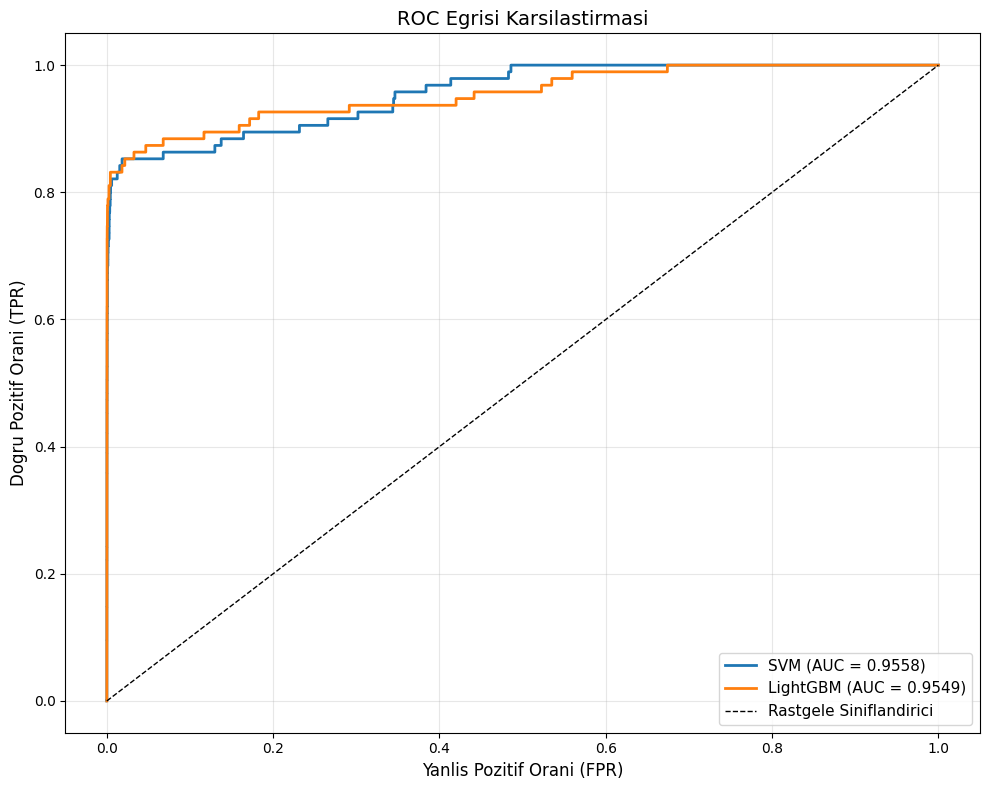

ROC Egrisi 'roc_curves.png' olarak kaydedildi


In [8]:
# ROC egrilerini hesapla
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pred_proba)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_pred_proba)

# ROC egrilerini ciz
plt.figure(figsize=(10, 8))

plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.4f})', linewidth=2)
plt.plot(lgbm_fpr, lgbm_tpr, label=f'LightGBM (AUC = {lgbm_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Siniflandirici', linewidth=1)

plt.xlabel('Yanlis Pozitif Orani (FPR)', fontsize=12)
plt.ylabel('Dogru Pozitif Orani (TPR)', fontsize=12)
plt.title('ROC Egrisi Karsilastirmasi', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC Egrisi 'roc_curves.png' olarak kaydedildi")

## 7. Karisiklik Matrisleri

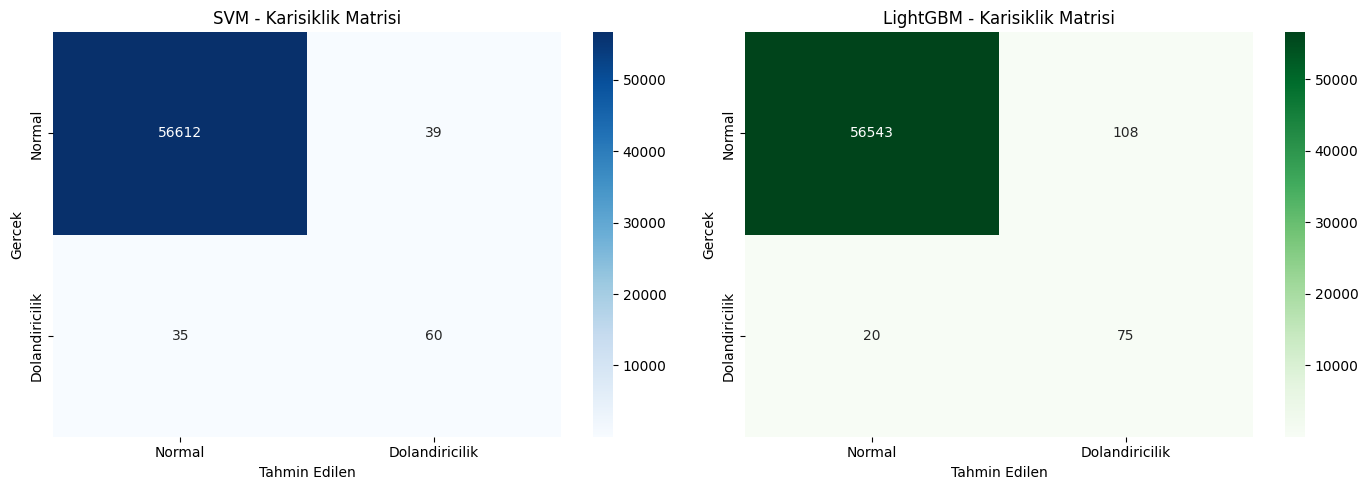

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SVM Karisiklik Matrisi
svm_cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Dolandiricilik'],
            yticklabels=['Normal', 'Dolandiricilik'])
axes[0].set_title('SVM - Karisiklik Matrisi', fontsize=12)
axes[0].set_xlabel('Tahmin Edilen')
axes[0].set_ylabel('Gercek')

# LightGBM Karisiklik Matrisi
lgbm_cm = confusion_matrix(y_test, lgbm_pred)
sns.heatmap(lgbm_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Normal', 'Dolandiricilik'],
            yticklabels=['Normal', 'Dolandiricilik'])
axes[1].set_title('LightGBM - Karisiklik Matrisi', fontsize=12)
axes[1].set_xlabel('Tahmin Edilen')
axes[1].set_ylabel('Gercek')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Sonuc Karsilastirma Tablosu

In [10]:
# Sonuc DataFrame olustur
results_df = pd.DataFrame({
    'Model': ['SVM (RBF)', 'LightGBM'],
    'Dogruluk': [svm_accuracy, lgbm_accuracy],
    'Kesinlik': [svm_precision, lgbm_precision],
    'Duyarlilik': [svm_recall, lgbm_recall],
    'F1-Skoru': [svm_f1, lgbm_f1],
    'AUC': [svm_auc, lgbm_auc]
})

# Degerleri yuvarla
results_df = results_df.round(4)

# Sonuclari goster
print("=" * 70)
print("MODEL KARSILASTIRMA SONUCLARI")
print("=" * 70)
print(results_df.to_string(index=False))

# Sonuclari CSV dosyasina kaydet
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nSonuclar 'model_comparison_results.csv' dosyasina kaydedildi")

MODEL KARSILASTIRMA SONUCLARI
    Model  Dogruluk  Kesinlik  Duyarlilik  F1-Skoru    AUC
SVM (RBF)    0.9987    0.6061      0.6316    0.6186 0.9558
 LightGBM    0.9977    0.4098      0.7895    0.5396 0.9549

Sonuclar 'model_comparison_results.csv' dosyasina kaydedildi


## 9. En Iyi Model Analizi

In [11]:
# F1-Skoruna gore en iyi modeli belirle
best_model_idx = results_df['F1-Skoru'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print("=" * 70)
print("SON ANALIZ")
print("=" * 70)
print(f"\nEN IYI MODEL: {best_model_name}")
print(f"\nEn Iyi Model Metrikleri:")
print(results_df.loc[best_model_idx].to_string())

print("\n" + "-" * 70)
print("ANALIZ NOTLARI:")
print("-" * 70)
print("""
1. SVM ve LightGBM Karsilastirmasi:
   - SVM: Margin tabanli, yuksek boyutlu verilerde etkili
   - LightGBM: Hizli ve verimli gradient boosting algoritmasi

2. StandardScaler Etkisi:
   - SVM icin olcekleme kritik oneme sahip (RBF kernel mesafe hesaplar)
   - LightGBM agac tabanli oldugu icin olceklemeye duyarsiz

3. Dengesiz Veri Seti:
   - Dolandiricilik vakalari cok nadir (%0.17)
   - SVM'de class_weight='balanced' kullanildi
   - LightGBM'de scale_pos_weight kullanildi
   - F1-Skoru ve AUC daha guvenilir metriklerdir

4. Asiri Ogrenme/Yetersiz Ogrenme:
   - SVM: C parametresi cok yuksekse asiri ogrenme riski
   - LightGBM: num_leaves ve max_depth ile kontrol edilir
   - Capraz dogrulama ile kontrol edildi

5. Oneriler:
   - LightGBM genellikle daha hizli ve olceklenebilir
   - SVM buyuk veri setlerinde yavas olabilir
   - Dolandiricilik tespitinde Duyarlilik (Recall) onemli
""")

SON ANALIZ

EN IYI MODEL: SVM (RBF)

En Iyi Model Metrikleri:
Model         SVM (RBF)
Dogruluk         0.9987
Kesinlik         0.6061
Duyarlilik       0.6316
F1-Skoru         0.6186
AUC              0.9558

----------------------------------------------------------------------
ANALIZ NOTLARI:
----------------------------------------------------------------------

1. SVM ve LightGBM Karsilastirmasi:
   - SVM: Margin tabanli, yuksek boyutlu verilerde etkili
   - LightGBM: Hizli ve verimli gradient boosting algoritmasi

2. StandardScaler Etkisi:
   - SVM icin olcekleme kritik oneme sahip (RBF kernel mesafe hesaplar)
   - LightGBM agac tabanli oldugu icin olceklemeye duyarsiz

3. Dengesiz Veri Seti:
   - Dolandiricilik vakalari cok nadir (%0.17)
   - SVM'de class_weight='balanced' kullanildi
   - LightGBM'de scale_pos_weight kullanildi
   - F1-Skoru ve AUC daha guvenilir metriklerdir

4. Asiri Ogrenme/Yetersiz Ogrenme:
   - SVM: C parametresi cok yuksekse asiri ogrenme riski
   - LightGBM:

## 10. Ozellik Onemi (LightGBM)

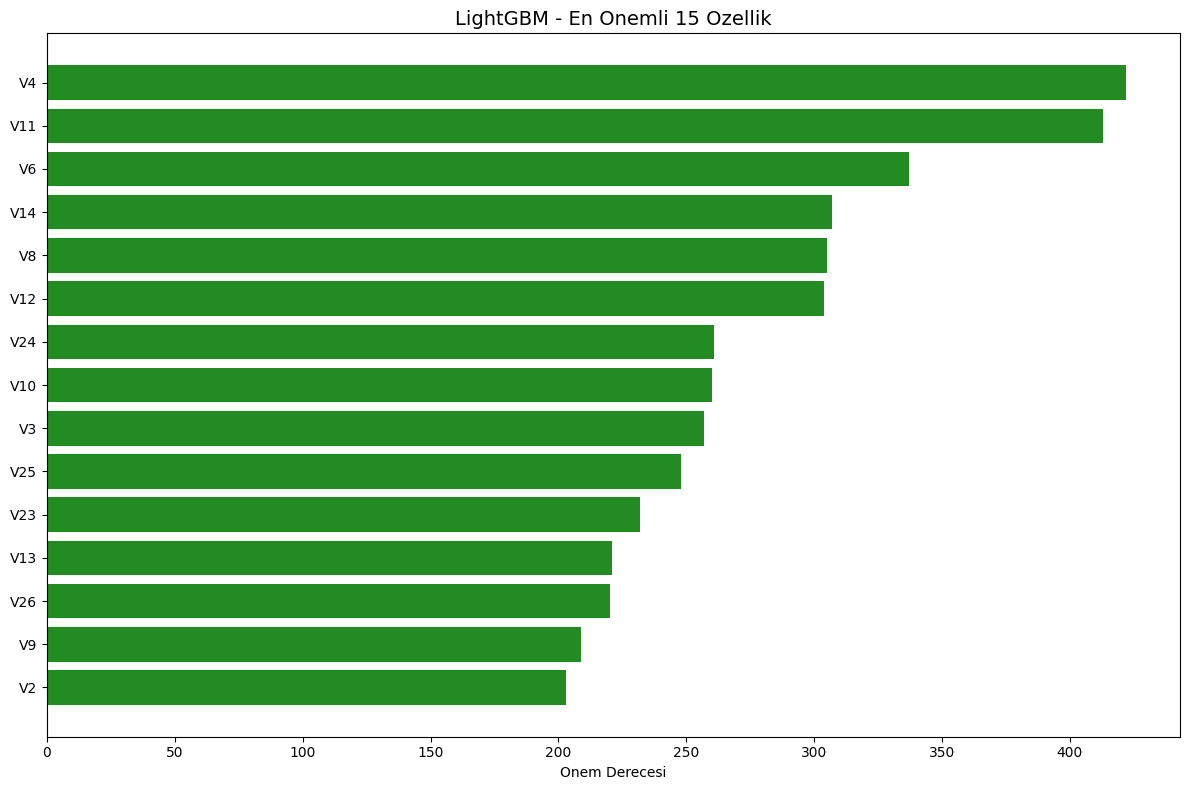

In [12]:
# LightGBM ozellik onemini gorsellestir
plt.figure(figsize=(12, 8))

lgbm_importance = pd.DataFrame({
    'Ozellik': X.columns,
    'Onem': best_lgbm.feature_importances_
}).sort_values('Onem', ascending=True).tail(15)

plt.barh(lgbm_importance['Ozellik'], lgbm_importance['Onem'], color='forestgreen')
plt.title('LightGBM - En Onemli 15 Ozellik', fontsize=14)
plt.xlabel('Onem Derecesi')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Ozet

Bu notebook sunlari uyguladi:
1. Support Vector Machine (SVM - RBF Kernel) - Hiperparametre Ayarli (C, gamma)
2. LightGBM (Boosting Ensemble) - Hiperparametre Ayarli (num_leaves, learning_rate, n_estimators, max_depth)
3. StandardScaler - Margin tabanli algoritmalar icin zorunlu
4. Tam degerlendirme metrikleri (Dogruluk, Kesinlik, Duyarlilik, F1-Skoru, AUC)
5. Her iki model icin ROC Egrileri
6. Karisiklik Matrisleri
7. Tum metriklerle karsilastirma tablosu
8. LightGBM ozellik onemi analizi

**Veri Kaynagi:** `data/processed/creditcard_clean.csv` (Data_Cleaning.ipynb dosyasinda on islenmis)